### Example on workflow for trainable parameter optimization of quantum kernels

Exemplary shown for:

- Fidelity Quantum Kernel
- simple 1D regression problem
- Optimization of NLL based on ADAM optimizer
- QGPR for solving the final regression problem

In [5]:
# necessary imports
import numpy as np

from squlearn.util import Executor
from squlearn.feature_map import ChebPQC
from squlearn.kernel import FidelityKernel
from squlearn.kernel import QGPR
from squlearn.kernel.optimization import KernelOptimizer
from squlearn.kernel.optimization import NLL

In [6]:
# Generate training data.
def func(x):
    return np.sin(3 * x) * x * x


noise_std = 0.1
X_test = np.linspace(-1, 1, 100)
Y_test = func(X_test)
X_train = np.linspace(-1, 1, 15)
Y_train = func(X_train) + np.random.normal(scale=noise_std, size=len(X_train))

In [7]:
# set up fidelity quantum kernel
num_qubits = 4
fmap = ChebPQC(num_qubits, num_features=1, num_layers=2)
q_kernel = FidelityKernel(
    feature_map=fmap, executor=Executor("statevector_simulator"), parameter_seed=0
)

In [8]:
# set up the optimizer, the usage of NLL as loss functoin as well as initialiing the KernelOptimizer
from squlearn.optimizers import Adam

adam = Adam(options={"maxiter": 20, "lr": 0.1})
nll_loss = NLL(quantum_kernel=q_kernel, sigma=noise_std**2)
optimizer = KernelOptimizer(loss=nll_loss, optimizer=adam)

<i>Note:</i> The following cell takes approx. 20s to finish

In [9]:
# run the optimization

opt_result = optimizer.run_optimization(x=X_train.reshape(-1, 1), y=Y_train)

In [15]:
# Perform the QGPR with the optimized parameters assigned to the
# FQK defined above

# Retrieve the optimial paramaters from the optimizer result
optimal_parameters = opt_result.x

# assign the optimal parameters to the FQK defined above
q_kernel.assign_parameters(optimal_parameters)

# Set up the QGPR and perform the fit and predict steps
qgpr_model = QGPR(quantum_kernel=q_kernel, sigma=noise_std**2)
qgpr_model.fit(X_train=X_train.reshape(-1, 1), y_train=Y_train)
qgpr_mean, qgpr_std = qgpr_model.predict(X_test=X_test.reshape(-1, 1), return_std=True)

Regularizing full Gram matrix
Reconstruction error -5.542871717167941e-12


Text(0, 0.5, '$f(x)$')

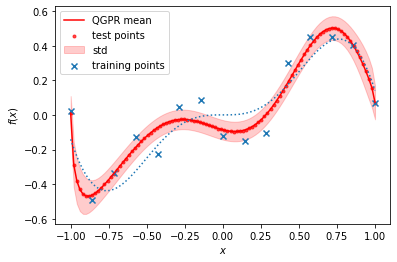

In [16]:
from matplotlib import pyplot as plt

# plot result
plt.plot(X_test.reshape(-1, 1), qgpr_mean, color="red", label="QGPR mean")
plt.scatter(
    X_test.reshape(-1, 1), qgpr_mean, marker=".", label="test points", color="red", alpha=0.7
)
plt.fill_between(
    X_test.reshape(-1),
    qgpr_mean.reshape(-1) - qgpr_std,
    qgpr_mean.reshape(-1) + qgpr_std,
    color="red",
    label="std",
    alpha=0.2,
)
plt.scatter(X_train, Y_train, marker="x", label="training points")
plt.plot(X_test, Y_test, linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")